In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .05
X_MIN = -50
X_MAX = 50

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N
    
def get_jac(th_0, mu_j, sgm_j, eps):
    D = len(th_0)
    jac = np.nan*np.zeros((D, D))
    
    alph_0 = alph(th_0, 0, 0, D, mu_j, sgm_j)
    
    for d in range(D):
        alph_d = alph(th_0 + eps*np.eye(D)[:, d], 0, 0, D, mu_j, sgm_j)
        jac[:, d] = (alph_d-alph_0)/eps
        
    return jac

In [3]:
def get_lam_max(D, mu_0, mu_1, sgm_0, sgm_1, eps=1e-12):
    """Numeric estimate of maximum eigenvalue of MFT dynamics at central fixed point."""
    th_0 = np.ones(D)/D  # central fixed point
    
    # means
    mu_j = np.zeros((D, D))
    mu_j[np.eye(D, dtype=bool)] = mu_0
    mu_j[~np.eye(D, dtype=bool)] = mu_1
    
    # sgms
    sgm_j = np.zeros((D, D))
    sgm_j[np.eye(D, dtype=bool)] = sgm_0
    sgm_j[~np.eye(D, dtype=bool)] = sgm_1
    
    # estimate jacobian at th_0
    jac = get_jac(th_0, mu_j, sgm_j, eps)
    
    # get eigenvalues (note that we expect a zero eigenvalue in the (1, 1, ..., 1) direction)
    evs, evecs = np.linalg.eig(jac)
    
    lam_max = np.max(evs)
    
    return lam_max, evs, evecs

In [4]:
def get_active(ths, t_1):
    ths_mn = ths[t_1:, :].mean(0)  # ppln time average
    matv = ths_mn > np.max(ths_mn/2)  # mask over active labels
    iatv = matv.nonzero()[0]  # idxs of active labels
    return iatv

## Varying $\sigma_0/\sigma_1$ and $D$

In [5]:
MU_0S = [0, -.1, 0]
MU_1S = [0, 0, -.1]
SGM_0 = 1

DS = np.arange(1, 41)

DSGM_1 = .01
SGM_1S = np.arange(0, .25+DSGM_1, DSGM_1)

lam_maxs_all = []

for MU_0, MU_1 in zip(MU_0S, MU_1S):
    print(f'(MU_0,MU_1) ({MU_0},{MU_1})')
    lam_maxs = np.nan*np.zeros((len(DS), len(SGM_1S)))

    print('D')
    for cd, d in enumerate(DS):
        sys.stdout.write(f' {d}')
        for csgm_1, SGM_1 in enumerate(SGM_1S):
            lam_maxs[cd, csgm_1] = get_lam_max(d, MU_0, MU_1, SGM_0, SGM_1)[0]
    
    lam_maxs_all.append(lam_maxs.copy())

(MU_0,MU_1) (0,0)
D
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40(MU_0,MU_1) (-0.1,0)
D
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40(MU_0,MU_1) (0,-0.1)
D
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

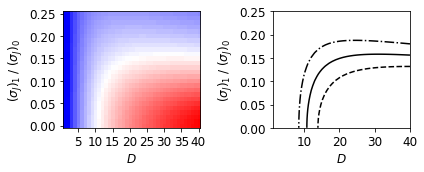

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)
axs[0].matshow(lam_maxs_all[0].T, origin='lower', extent=[.5, DS[-1] + .5, -DSGM_1/2, SGM_1S[-1]+DSGM_1/2], cmap='seismic', vmin=-1, vmax=3)
axs[0].set_aspect('auto')

labels = []
lss = ['-', '--', '-.']
for MU_0, MU_1, lam_maxs, ls in zip(MU_0S, MU_1S, lam_maxs_all, lss):
    axs[1].contour(*np.meshgrid(DS, SGM_1S), lam_maxs.T, levels=[1], colors='k', linestyles=ls)
    labels.append('$\mu =$')# + f'{MU_0}')

for ax in axs:
    ax.xaxis.tick_bottom()
    set_plot(ax, x_label=r'$D$', y_label=r'$(\sigma_J)_1 \; / \; (\sigma_J)_0$')
    
fig.savefig('figs/main/4_multi_unif_stability_portrait.svg')